<a href="https://colab.research.google.com/github/DucBox/Finger-Classification/blob/main/Collect_and_Process_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import cv2
import time
import os
import subprocess
import io
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from multiprocessing import Pool
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from IPython import display
from matplotlib import animation
from matplotlib.patches import Rectangle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [ ]:
!pip install Pillow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!git clone https://github.com/interactionlab/CapFingerId.git

Cloning into 'CapFingerId'...
remote: Enumerating objects: 219, done.
remote: Total 219 (delta 0), reused 0 (delta 0), pack-reused 219
Receiving objects: 100% (219/219), 130.79 MiB | 13.19 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (205/205), done.


In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/FingerClassification/data.pkl")

In [ ]:
df = ""
PATH = "/content/CapFingerId/data/"

for filename in os.listdir(PATH):
    if filename.endswith(".txt"):
        dfTemp = pd.read_csv(PATH + filename, header=None, names=["Participant", "Handedness", "Finger", "Task", "Ignore", "MatrixStr"], delimiter=";")
        if (type(df) is str):
            df = dfTemp
        else:
            df = pd.concat([df, dfTemp])
    else:
        continue


# Remove the "Ignore" column
df = df.drop('Ignore', axis = 1)

In [ ]:
df.head()

,Participant,Handedness,Finger,Task,MatrixStr
0,14,right,ring,TAP,"1510247037,185488055,5,224,0,0,1,0,1,3,0,0,0,4..."
1,14,right,ring,TAP,"1510247037,255665659,5,224,0,0,1,0,1,3,0,0,0,4..."
2,14,right,ring,TAP,"1510247037,255665659,5,224,0,0,1,0,1,3,0,0,0,4..."
3,14,right,ring,TAP,"1510247037,326155034,5,224,0,0,1,0,1,3,0,0,0,4..."
4,14,right,ring,TAP,"1510247037,397380190,5,224,0,0,1,0,1,3,0,0,0,4..."


In [ ]:
df = df[(df.Finger == "index") | (df.Finger == "thumb")].copy()


In [ ]:
len(df)

183457

In [ ]:
df = df[df.Task != "PAUSE"]

In [ ]:
%%time
temp_var = None
def transform_to_matrix(s):
    matrix = s.replace("\n", "")
    matrix = matrix.split(",")

    if (len(matrix) != 408):
        return -1, -1

    matrix = matrix[:407]

    # determine timestamp
    timestamp = str(matrix[0]) + str(matrix[1][:3])
    timestamp = int(timestamp)

    matrix = np.array(matrix[2:]).reshape(27, 15)

    matrix[matrix==''] = '0'
    matrix[matrix=='-'] = '0'

    try:
        matrix = matrix.astype(int)
    except ValueError:
        return -1, -1

    return matrix, timestamp

df['Matrix'] = df.MatrixStr.apply(lambda x : transform_to_matrix(x)[0])
df['Timestamp'] = df.MatrixStr.apply(lambda x : transform_to_matrix(x)[1])
df = df.drop(['MatrixStr'], axis=1)
df = df[~(df.Timestamp == -1)]

CPU times: user 6min 39s, sys: 6.87 s, total: 6min 46s
Wall time: 6min 48s


In [ ]:
THRESHOLD = 30

# Recursive blob detection
def blob_detection(matrix, x, y, found):
    if x > 0 and x < len(matrix[0]) and y > 0 and y < len(matrix) and matrix[y][x] > THRESHOLD and ((x,y) not in found):
        found.append((x, y))
        blob_detection(matrix, x + 1, y, found) # right
        blob_detection(matrix, x - 1, y, found) # left
        blob_detection(matrix, x, y + 1, found) # top
        blob_detection(matrix, x, y - 1, found) # down

# Returns Blob Coordinates, connected tiles > 30
def get_blobs(matrix):
    blobs = []
    founds = []
    for y in range(0, len(matrix)):
        for x in range(0, len(matrix[0])):

            # blob detection
            found = []
            blob_detection(matrix, x, y, found)

            if (len(found) > 0):
                sorted_by_x = sorted(found, key=lambda x: x[0])
                sorted_by_y = sorted(found, key=lambda x: x[1])
                x_min = sorted_by_x[0][0]
                y_min = sorted_by_y[0][1]
                x_max = sorted_by_x[len(sorted_by_x) - 1][0]
                y_max = sorted_by_y[len(sorted_by_y) - 1][1]

                if (x_min - 1, x_max + 1, y_min - 1, y_max + 1) not in blobs and ((x_max - x_min) * (y_max - y_min)) > 1:
                    blobs.append((x_min - 1, x_max + 1, y_min - 1, y_max + 1))
                    founds.append(len(found))

    return blobs

# Returns the cutted blob
def get_blob_contents(matrix, blob_coordinates):
    matrices = []
    for c in blob_coordinates:
        matrices.append(matrix[c[2]:c[3], c[0]:c[1]])
    return matrices


# Returns the coordinates of the rectangle containing the touch blob
def get_plt_rect(blob_coordinates):
    return Rectangle((blob_coordinates[2] - 0.5, blob_coordinates[0]  - 0.5),
     (blob_coordinates[1] - blob_coordinates[0]) + 1, (blob_coordinates[3] - blob_coordinates[2]) + 1,
                     fill=None, alpha=1, lw=2, color='lime')

In [ ]:
%%time
df['BlobCoords'] = df.Matrix.apply(lambda x : get_blobs(x))
df['BlobCount'] = df.BlobCoords.apply(lambda x : len(x))
df['Blobs'] = [get_blob_contents(df.Matrix.iloc[i], df.BlobCoords.iloc[i]) for i in range(len(df))]

# remove all empty images and images with more than one blob
df = df[df.BlobCount == 1]

CPU times: user 8min 5s, sys: 1.65 s, total: 8min 7s
Wall time: 8min 13s


In [ ]:
df.tail()

In [ ]:
df['Blobs'] = df['Blobs'].apply(lambda x: np.array(x))
df['Blobs'] = df['Blobs'].apply(lambda x: np.squeeze(np.array(x)))

In [ ]:
def delete_negative(blobs):
    blobs = np.where(blobs < 0, 0, blobs)
    return blobs
df['Blobs']=df.Blobs.apply(lambda x: delete_negative(x))

In [ ]:
def generate_blob_img(blobs):

    # Thêm padding vào blob để đạt kích thước 27x15, với giá trị padding là 0
    return np.pad(blobs, ((0, 27 - blobs.shape[0]), (0, 15 - blobs.shape[1])), mode='constant', constant_values=0)


df['BlobImage'] = df.Blobs.apply(lambda x : generate_blob_img(x))

# Creating a flattened version of the blob image for basic ML approaches
df['BlobImgFlattened'] = df.BlobImage.apply(lambda x : x.flatten())

In [ ]:
# Thống kê kích thước và số lượng tương ứng
from collections import OrderedDict

size_counts = {}

for blob in df['Blobs']:
    size = blob.shape  # Lấy kích thước của mảng
    if size in size_counts:
        size_counts[size] += 1
    else:
        size_counts[size] = 1

size_counts

sorted_size_counts = OrderedDict(sorted(size_counts.items(), key=lambda x: x[0]))

sorted_size_counts

In [ ]:
df = df[df['Blobs'].apply(lambda x: x.shape[0] < 10 and x.shape[1] < 10)]

In [ ]:
#Resize with OpenCV dùng bilinear interpolation
import cv2
import numpy as np

def resize_blob_with_opencv(blob):
    # Chuyển đổi blob thành mảng NumPy nếu chưa phải
    blob_array = blob

    blob_array = blob_array.astype(np.float64)

    # Sử dụng cv2.resize để thay đổi kích thước mảng về 8x8 với bilinear interpolation
    resized_blob = cv2.resize(blob_array, (8, 8), interpolation=cv2.INTER_LINEAR)

    return resized_blob

df['Resized_Blobs'] = df['Blobs'].apply(resize_blob_with_opencv)


In [ ]:
df.head()

PROCESS WITH HOG

In [ ]:

# Khởi tạo HOGDescriptor
hog = cv2.HOGDescriptor(_winSize=(27, 15),
                        _blockSize=(15, 15),
                        _blockStride=(1, 1),
                        _cellSize=(5, 5),
                        _nbins=9)

def compute_hog(matrix_8x8):
    # matrix_normalized = (matrix_8x8 - np.min(matrix_8x8)) / (np.max(matrix_8x8) - np.min(matrix_8x8))
    matrix_8x8_uint8 = np.uint8(matrix_8x8)
    # Tính toán HOG Descriptors
    hog_descriptors = hog.compute(matrix_8x8_uint8)
    return hog_descriptors

# Tạo cột mới "HOG"
df['HOG1'] = df['BlobImage'].apply(lambda x: compute_hog(x))

In [ ]:
# Thống kê kích thước và số lượng tương ứng
from collections import OrderedDict

size_counts = {}

for blob in df['BlobImage']:
    size = blob.shape  # Lấy kích thước của mảng
    if size in size_counts:
        size_counts[size] += 1
    else:
        size_counts[size] = 1

size_counts

sorted_size_counts = OrderedDict(sorted(size_counts.items(), key=lambda x: x[0]))

sorted_size_counts

OrderedDict([((27, 15), 95563)])

In [ ]:
# In ra kích thước và kiểu dữ liệu của 5 blobs đầu tiên
for i, blob in enumerate(df['HOG'][:5]):
    blob_array = np.array(blob)
    print(f"HOG_Vector {i}: shape = {blob_array.shape}, dtype = {blob_array.dtype}")
for i, blob in enumerate(df['BlobImage'][:5]):
    blob_array = np.array(blob)
    print(f"Blob {i}: shape = {blob_array.shape}, dtype = {blob_array.dtype}")

HOG_Vector 0: shape = (900,), dtype = float32
HOG_Vector 1: shape = (900,), dtype = float32
HOG_Vector 2: shape = (900,), dtype = float32
HOG_Vector 3: shape = (900,), dtype = float32
HOG_Vector 4: shape = (900,), dtype = float32
Blob 0: shape = (12, 12), dtype = int64
Blob 1: shape = (12, 12), dtype = int64
Blob 2: shape = (12, 12), dtype = int64
Blob 3: shape = (12, 12), dtype = int64
Blob 4: shape = (12, 12), dtype = int64


In [ ]:
df = df.drop('R-HOG', axis=1)
df = df.drop('C-HOG', axis=1)
df = df.drop('CompressHOG', axis=1)

In [ ]:
df = df.drop('HOG', axis=1)

In [ ]:
df = df.drop('HOG_new', axis=1)

In [ ]:
def blob_normalized(blobs):
    blob_scale = (blobs - np.min(blobs))/(np.max(blobs)-np.min(blobs))
    return blob_scale

df['Blob_Scale'] = df['BlobImage'].apply(lambda x : blob_normalized(x))

In [ ]:
# Tìm giá trị nhỏ nhất trong tất cả các ma trận trong cột 'BlobImage'
min_value = df['Scaled_Blobs'].apply(lambda x: x.max()).max()
min_value

255

In [ ]:
has_negative_values = any(cell[cell < 0].any() for cell in df['Blobs'])

has_negative_values

False

In [ ]:
df['BlobImage'].iloc[0]

In [ ]:
plt.imshow(df['BlobImage'].iloc[0], cmap='gray')

In [ ]:
# Define the size factor for scaling up
scale_factor = 5

# Create an empty image array based on the provided data
data = df.Blobs.iloc[0]
# Create a PIL image from the numpy array
image = Image.fromarray(data.astype(np.uint8), 'L')

# Upscale the image by a factor of 5 using the Lanczos resampling algorithm
upscaled_image = image.resize((image.size[0]*scale_factor, image.size[1]*scale_factor), Image.LANCZOS)

# Convert the upscaled PIL image to a numpy array for plotting
upscaled_image_array = np.array(upscaled_image)



# Plot the upscaled image
plt.imshow(upscaled_image_array, cmap='gray', aspect='equal')
plt.colorbar()
plt.axis('off')  # No axis for an upscaled image
plt.show()



In [ ]:
# Define the size factor for scaling up
scale_factor = 5
def upscale_image(blob, scale_factor):
    # Create a PIL image from the numpy array
    image = Image.fromarray(blob.astype(np.uint8), 'L')

    # Upscale the image using the Lanczos resampling algorithm
    upscaled_image = image.resize(
        (image.size[0] * scale_factor, image.size[1] * scale_factor), Image.LANCZOS
    )

    # Convert the upscaled PIL image to a numpy array for further use
    return np.array(upscaled_image)

# Now apply this function to each item in the 'Blobs' column
df['Scaled_Blobs'] = df['Blobs'].apply(lambda x: upscale_image(x, scale_factor))

In [ ]:
df.Blobs.iloc[0]

In [ ]:
upscaled_image_array

In [ ]:
df.iloc[2000]

VÍ DỤ

In [ ]:
img = df.Scaled_Blobs.iloc[0]

In [ ]:
df.Scaled_Blobs.iloc[0]
# df.Blobs.iloc[0]

array([[  2,   3,   5,   6,   9,  11,  13,  16,  17,  16,  15,  14,  11,
          8,   6,   4,   4,   2,   1,   1],
       [  2,   3,   5,   7,   9,  12,  15,  18,  21,  22,  22,  21,  19,
         15,  12,   8,   6,   4,   2,   1],
       [  2,   3,   5,   7,  10,  13,  17,  22,  27,   0,   0,   0,   0,
         24,  19,  13,   9,   5,   2,   0],
       [  2,   3,   5,   7,  11,  15,  20,  27,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   7,   2,   0],
       [  1,   3,   5,   8,  12,  17,  24,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   2,   0],
       [  1,   3,   6,   9,  13,  19,  28,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   4,   0],
       [  1,   4,   6,   9,  13,  21,  32,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   6,   0],
       [  1,   4,   6,   9,  13,  21,  33,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  10,   1],
       [  1,   4,   6,   8,  12,  19,  31,   0,   0,   0,   0, 130,   0,
          0,   0,   0,   0,   0,  15,   6],
       [  2,   5,   6,   7,  10,  17,  28,   0,   0,   0,   0, 127, 127,
          0,   0,   0,   0,   0,  20,  12],
       [  3,   5,   5,   7,   9,  14,  23,   0,   0,   0,   0,   0, 120,
          0,   0,   0,   0,   0,  25,  17],
       [  4,   5,   5,   6,   7,  11,  19,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  28,  22],
       [  4,   5,   5,   5,   6,   9,  16,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  31,  25],
       [  4,   5,   5,   5,   5,   7,  14,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  33,  28],
       [  5,   5,   5,   4,   5,   6,  12,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  35,  30]], dtype=uint8)

Otsu Binarization

In [ ]:

# Áp dụng ngưỡng để chuyển đổi ảnh sang ảnh nhị phân
# Áp dụng Otsu's binarization
ret, thresh = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
print(cv.THRESH_BINARY, cv.THRESH_OTSU)
# Tìm các đường viền
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# Chọn đường viền đầu tiên và tính các moment
cnt = contours[0]
M = cv.moments(cnt)
print(M)


0 8
{'m00': 108.5, 'm10': 1502.1666666666665, 'm01': 1389.1666666666665, 'm20': 21697.75, 'm11': 19299.708333333332, 'm02': 18791.75, 'm30': 325433.05000000005, 'm21': 279327.01666666666, 'm12': 261753.35, 'm03': 266721.55, 'mu20': 900.4717101894566, 'mu11': 66.898553507428, 'mu02': 1005.7220942140339, 'mu30': 97.06874366343254, 'mu21': -329.9104846772516, 'mu12': -128.7416082469772, 'mu03': 370.3617349494016, 'nu20': 0.07649104548318772, 'nu11': 0.005682732995597953, 'nu02': 0.08543159499790048, 'nu30': 0.0007915986834448972, 'nu21': -0.002690430466790542, 'nu12': -0.0010498918987377163, 'nu03': 0.003020311695810681}


Adaptive Threshold

In [ ]:
thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

In [ ]:
# Tạo một màu khác, ví dụ: màu đỏ (BGR)
color = (0, 0, 255)  # BGR color for red

# Tìm contour trong ảnh nhị phân
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Chọn contour lớn nhất
largest_contour = max(contours, key=cv2.contourArea)

# Tìm elip bao xung quanh contour lớn nhất
ellipse = cv2.fitEllipse(largest_contour)

# Sao chép ảnh gốc để vẽ elip lên đó
img_with_ellipse = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert to BGR for color image

# Vẽ elip lên ảnh gốc với màu đã chọn
cv2.ellipse(img_with_ellipse, ellipse, color, 2)

In [ ]:
# Lấy thông tin của elip từ contour lớn nhất
major_axis, minor_axis = ellipse[1]
angle = ellipse[2]

# In ra thông tin
print("Độ dài trục lớn của elip:", major_axis)
print("Độ dài trục nhỏ của elip:", minor_axis)
print("Góc xoay của elip (theta):", angle)

Độ dài trục lớn của elip: 18.344289779663086
Độ dài trục nhỏ của elip: 20.378353118896484
Góc xoay của elip (theta): 60.531524658203125


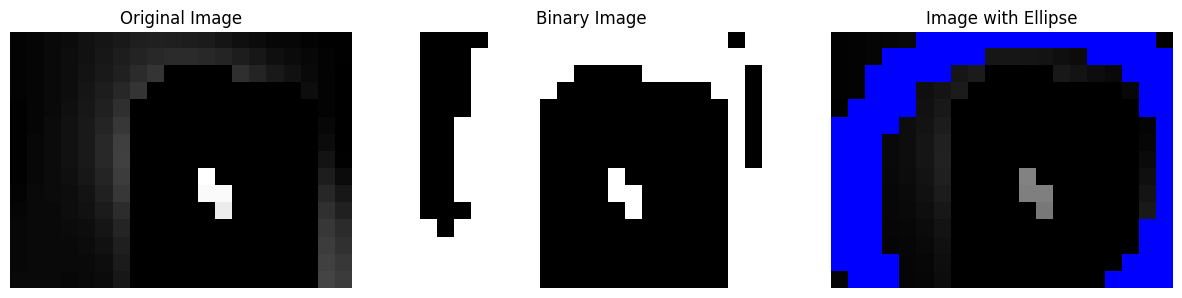

In [ ]:
import matplotlib.pyplot as plt

# Đặt kích thước của hình ảnh được hiển thị
plt.figure(figsize=(15, 5))

# Hiển thị ảnh gốc
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Hiển thị ảnh nhị phân
plt.subplot(1, 3, 2)
plt.imshow(thresh, cmap='gray')
plt.title('Binary Image')
plt.axis('off')

# Hiển thị ảnh gốc với elip bao xung quanh
plt.subplot(1, 3, 3)
plt.imshow(img_with_ellipse)
plt.axis('off')
plt.title('Image with Ellipse')
plt.show()


plt.show()


In [ ]:
# Hàm để kiểm tra xem có thể tìm contour và fit elip được không
def check_contour_and_ellipse(img):
    # Áp dụng adaptive thresholding
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    # Tìm contour trong ảnh nhị phân
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Nếu không tìm thấy contour hoặc không đủ điểm để fit elip
    if len(contours) == 0 or cv2.contourArea(max(contours, key=cv2.contourArea)) < 5:
        return False
    else:
        return True
count = 0
# Duyệt qua toàn bộ DataFrame
for img_array in df['Scaled_Blobs']:
    # Kiểm tra contour và elip cho mỗi mảng numpy trong cột 'Scaled_Blobs'
    if check_contour_and_ellipse(img_array):
        continue
    else:
        count = count + 1
print(count)

0


In [ ]:
df.Angle.iloc[0]

11.165919303894043

In [ ]:
df.iloc[0]

In [ ]:
# Tìm đường viền lớn nhất dựa trên diện tích
largest_contour = max(contours, key=cv.contourArea)

# Đơn giản hóa đường viền để loại bỏ các chi tiết không cần thiết
epsilon = 0.01 * cv.arcLength(largest_contour, True)
approx = cv.approxPolyDP(largest_contour, epsilon, True)

    # Kiểm tra đường viền sau khi đơn giản có đủ điểm để khớp elip không
if len(approx) >= 5:
    ellipse = cv.fitEllipse(approx)
    img_color = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.ellipse(img_color, ellipse, (0, 268, 0), 2)

        # Hiển thị hình ảnh
    plt.imshow(cv.cvtColor(img_color, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("Không đủ điểm để khớp elip.")
    # Hiển thị ảnh gốc
    plt.imshow(img, cmap='gray')
    plt.show()

In [ ]:
# Hàm tính diện tích của elip
def calculate_area(a, b):
    return math.pi * a * b

# Hàm để xác định các thông số của elip từ ảnh xám
def find_ellipse_params(img):
    # Áp dụng adaptive thresholding
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    # Tìm contour trong ảnh nhị phân
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Nếu tìm thấy contour
    if len(contours) > 0:
        # Tìm elip bao xung quanh contour
        ellipse = cv2.fitEllipse(max(contours, key=cv2.contourArea))
        # Trả về các thông số của elip
        major_axis = ellipse[1][0]
        minor_axis = ellipse[1][1]
        area = calculate_area(major_axis / 2, minor_axis / 2)
        angle = ellipse[2]
        return major_axis, minor_axis, area, angle
    else:
        return None, None, None, None

# Tạo các cột mới trong DataFrame để lưu thông tin của elip
df['Major_Axis'] = np.nan
df['Minor_Axis'] = np.nan
df['Area'] = np.nan
df['Angle'] = np.nan

# Duyệt qua toàn bộ DataFrame
for index, row in df.iterrows():
    # Xác định các thông số của elip cho mỗi ảnh trong cột 'Scaled_Blobs'
    major_axis, minor_axis, area, angle = find_ellipse_params(row['Scaled_Blobs'])
    # Lưu các thông số vào DataFrame
    df.at[index, 'Major_Axis'] = major_axis
    df.at[index, 'Minor_Axis'] = minor_axis
    df.at[index, 'Area'] = area
    df.at[index, 'Angle'] = angle

# Hiển thị DataFrame sau khi đã thêm thông tin về elip
df.head()


,Participant,Handedness,Finger,Task,Matrix,Timestamp,BlobCoords,BlobCount,Blobs,BlobImage,BlobImgFlattened,Scaled_Blobs,Major_Axis,Minor_Axis,Area,Angle
26,7,right,index,SCROLL,"[[0, -1, 0, -3, 0, 0, 2, 1, 0, 1, -2, 2, 0, 1,...",1509965139675,"[(9, 13, 11, 16)]",1,"[[4, 9, 13, 5], [5, 31, 57, 15], [13, 120, 220...","[[4, 9, 13, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[4, 9, 13, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[3, 4, 4, 5, 5, 6, 7, 9, 11, 11, 12, 13, 12, ...",9.804294,14.024021,107.988808,42.690639
27,7,right,index,SCROLL,"[[0, -1, 0, -3, 0, 0, 2, 1, 0, 1, -2, 2, 0, 1,...",1509965139675,"[(9, 13, 11, 16)]",1,"[[4, 9, 13, 5], [5, 31, 57, 15], [13, 120, 220...","[[4, 9, 13, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[4, 9, 13, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[3, 4, 4, 5, 5, 6, 7, 9, 11, 11, 12, 13, 12, ...",10.345570,12.890965,104.744140,47.160843
28,7,right,index,SCROLL,"[[0, -1, 0, -3, 0, 0, 2, 1, 0, 1, -2, 2, 0, 1,...",1509965139745,"[(8, 11, 11, 15)]",1,"[[4, 14, 12], [14, 78, 83], [18, 124, 140], [9...","[[4, 14, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4, 14, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[2, 2, 2, 3, 2, 4, 4, 4, 4, 2, 3, 2, 1, 0, 0]...",10.345570,12.890965,104.744140,47.160843
29,7,right,index,SCROLL,"[[0, -1, 0, -3, 0, 0, 2, 1, 0, 1, -2, 2, 0, 1,...",1509965139817,"[(6, 10, 10, 14)]",1,"[[6, 8, 15, 9], [15, 46, 69, 13], [23, 151, 23...","[[6, 8, 15, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[6, 8, 15, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[5, 5, 5, 5, 4, 4, 5, 6, 7, 9, 11, 12, 13, 12...",9.906662,13.497671,105.020981,54.622498
30,7,right,index,SCROLL,"[[0, -1, 0, -3, 0, 0, 2, 1, 0, 1, -2, 2, 0, 1,...",1509965139885,"[(4, 8, 10, 14)]",1,"[[5, 11, 23, 9], [9, 50, 155, 52], [13, 86, 23...","[[5, 11, 23, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5, 11, 23, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[4, 5, 4, 4, 5, 6, 5, 5, 4, 4, 3, 2, 2, 2, 2,...",8.511100,14.011619,93.662096,77.459496


In [ ]:
# Hàm tính diện tích của elip
def calculate_area(a, b):
    return math.pi * a * b
# Khởi tạo biến count bên ngoài hàm để theo dõi số lần không tìm thấy contour

count = 0

def find_ellipse_params(img):
    global count

    # Áp dụng adaptive thresholding
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    # Tìm contour trong ảnh nhị phân
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Nếu không tìm thấy contour
    if not contours:
        count += 1  # Tăng biến count lên 1

    # Chọn contour lớn nhất
    largest_contour = max(contours, key=cv2.contourArea)

    # Tìm elip bao xung quanh contour lớn nhất
    ellipse = cv2.fitEllipse(largest_contour)

    # Trả về các thông số của elip
    major_axis = ellipse[1][0]
    minor_axis = ellipse[1][1]
    area = calculate_area(major_axis / 2, minor_axis / 2)
    angle = ellipse[2]

    return major_axis, minor_axis, area, angle
# Tạo các cột mới trong DataFrame để lưu thông tin của elip
df['Major_Axis'] = np.nan
df['Minor_Axis'] = np.nan
df['Area'] = np.nan
df['Angle'] = np.nan

# Duyệt qua toàn bộ DataFrame
for index, row in df.iterrows():
    # Xác định các thông số của elip cho mỗi ảnh trong cột 'Scaled_Blobs'
    major_axis, minor_axis, area, angle = find_ellipse_params(row['Scaled_Blobs'])
    # Lưu các thông số vào DataFrame
    df.at[index, 'Major_Axis'] = major_axis
    df.at[index, 'Minor_Axis'] = minor_axis
    df.at[index, 'Area'] = area
    df.at[index, 'Angle'] = angle

In [ ]:
df.head()

,Participant,Handedness,Finger,Task,Matrix,Timestamp,BlobCoords,BlobCount,Blobs,BlobImage,BlobImgFlattened,Scaled_Blobs,Major_Axis,Minor_Axis,Area,Angle
26,7,right,index,SCROLL,"[[0, -1, 0, -3, 0, 0, 2, 1, 0, 1, -2, 2, 0, 1,...",1509965139675,"[(9, 13, 11, 16)]",1,"[[4, 9, 13, 5], [5, 31, 57, 15], [13, 120, 220...","[[4, 9, 13, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[4, 9, 13, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[3, 4, 4, 5, 5, 6, 7, 9, 11, 11, 12, 13, 12, ...",9.804294,14.024021,107.988808,42.690639
27,7,right,index,SCROLL,"[[0, -1, 0, -3, 0, 0, 2, 1, 0, 1, -2, 2, 0, 1,...",1509965139675,"[(9, 13, 11, 16)]",1,"[[4, 9, 13, 5], [5, 31, 57, 15], [13, 120, 220...","[[4, 9, 13, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[4, 9, 13, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[3, 4, 4, 5, 5, 6, 7, 9, 11, 11, 12, 13, 12, ...",10.345570,12.890965,104.744140,47.160843
28,7,right,index,SCROLL,"[[0, -1, 0, -3, 0, 0, 2, 1, 0, 1, -2, 2, 0, 1,...",1509965139745,"[(8, 11, 11, 15)]",1,"[[4, 14, 12], [14, 78, 83], [18, 124, 140], [9...","[[4, 14, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4, 14, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[2, 2, 2, 3, 2, 4, 4, 4, 4, 2, 3, 2, 1, 0, 0]...",10.345570,12.890965,104.744140,47.160843
29,7,right,index,SCROLL,"[[0, -1, 0, -3, 0, 0, 2, 1, 0, 1, -2, 2, 0, 1,...",1509965139817,"[(6, 10, 10, 14)]",1,"[[6, 8, 15, 9], [15, 46, 69, 13], [23, 151, 23...","[[6, 8, 15, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[6, 8, 15, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[5, 5, 5, 5, 4, 4, 5, 6, 7, 9, 11, 12, 13, 12...",9.906662,13.497671,105.020981,54.622498
30,7,right,index,SCROLL,"[[0, -1, 0, -3, 0, 0, 2, 1, 0, 1, -2, 2, 0, 1,...",1509965139885,"[(4, 8, 10, 14)]",1,"[[5, 11, 23, 9], [9, 50, 155, 52], [13, 86, 23...","[[5, 11, 23, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5, 11, 23, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[4, 5, 4, 4, 5, 6, 5, 5, 4, 4, 3, 2, 2, 2, 2,...",8.511100,14.011619,93.662096,77.459496


In [ ]:
plt.imshow(img, cmap='gray')

In [ ]:
len(df)

455709

In [ ]:
df.to_pickle('/content/drive/MyDrive/FingerClassification/Data/fulldata.pkl')